In [133]:
import os
import warnings
import matplotlib.pyplot as plt 

warnings.filterwarnings("ignore")  # avoid printing out absolute paths
os.chdir("../../..")
%matplotlib inline

In [134]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, RMSE, MAE, MAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# Исходники

In [135]:
data = pd.read_csv('E:\\Analytics\\Projects\\pytorch_forecating\\test2.csv', delimiter=';')

In [136]:
data.rename(columns={'r_date': 'date', 'fact': 'volume'}, inplace=True)
data.head()

,date,warehouse_id,type_flow_id,measure_unit_id,new_year,time_idx,volume
0,01.01.2018,28999900,2,1,1,0,0
1,01.01.2018,28999900,2,2,1,0,0
2,02.01.2018,28999900,2,1,0,1,1
3,02.01.2018,28999900,2,2,0,1,1
4,03.01.2018,28999900,1,1,0,2,534


In [137]:
data = data.loc[(data['type_flow_id'] == 1) & (data['measure_unit_id'] == 1) & (data['warehouse_id'] == 28953351)]  
#data = data.loc[(data['type_flow_id'] == 3)]
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)
data.tail(10)

,date,warehouse_id,type_flow_id,measure_unit_id,new_year,time_idx,volume
1172,07.04.2021,28953351,1,1,0,1192,3282
1173,08.04.2021,28953351,1,1,0,1193,6344
1174,09.04.2021,28953351,1,1,0,1194,3157
1175,10.04.2021,28953351,1,1,0,1195,3189
1176,11.04.2021,28953351,1,1,0,1196,1528
1177,12.04.2021,28953351,1,1,0,1197,4608
1178,13.04.2021,28953351,1,1,0,1198,4123
1179,14.04.2021,28953351,1,1,0,1199,4468
1180,15.04.2021,28953351,1,1,0,1200,3662
1181,16.04.2021,28953351,1,1,0,1201,3301


In [138]:
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y') # r_date в дату
#data['start_week'] = data['start_week'].astype('str').astype('category')
#data['end_week'] = data['end_week'].astype('str').astype('category')
data['warehouse_id'] = data['warehouse_id'].astype('str').astype('category')
data['type_flow_id'] = data['type_flow_id'].astype('str').astype('category')
data['measure_unit_id'] = data['measure_unit_id'].astype('str').astype('category')
data['new_year'] = data['new_year']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 0 to 1181
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1182 non-null   datetime64[ns]
 1   warehouse_id     1182 non-null   category      
 2   type_flow_id     1182 non-null   category      
 3   measure_unit_id  1182 non-null   category      
 4   new_year         1182 non-null   int64         
 5   time_idx         1182 non-null   int64         
 6   volume           1182 non-null   int64         
dtypes: category(3), datetime64[ns](1), int64(3)
memory usage: 40.9 KB


In [139]:
# add time index
# data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month * 31 + data["date"].dt.day
# data["time_idx"] -= data["time_idx"].min()

# add additional features
data["year"] = data.date.dt.year.astype(str).astype("category") 
data["month"] = data.date.dt.month.astype(str).astype("category") 
data["weekday"] = data.date.dt.weekday.astype(str).astype("category") 
# data["weekofyear"] = data.date.dt.weekofyear.astype(str).astype("category") 
# data["dayofyear"] = data.date.dt.dayofyear.astype(str).astype("category") 

# categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_wh"] = data.groupby(["time_idx", "warehouse_id", "measure_unit_id", "type_flow_id"], observed=True).volume.transform("mean")
data["avg_volume_by_weekday"] = data.groupby(["warehouse_id", "month", "weekday"], observed=True).volume.transform("mean")
data["avg_volume_by_mon"] = data.groupby(["warehouse_id", "month"], observed=True).volume.transform("mean")
data["avg_volume_by_type"] = data.groupby(["warehouse_id", "month", "type_flow_id"], observed=True).volume.transform("mean")
# data["avg_volume_by_type_wh"] = data.groupby(["warehouse_id", "type_flow_id"], observed=True).volume.transform("mean")
data["avg_volume_by_measure"] = data.groupby(["warehouse_id", "month", "measure_unit_id"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "new_year"     
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")

data.sample(20)

,date,warehouse_id,type_flow_id,measure_unit_id,new_year,time_idx,volume,year,month,weekday,log_volume,avg_volume_by_wh,avg_volume_by_weekday,avg_volume_by_mon,avg_volume_by_type,avg_volume_by_measure
802,2020-04-02,28953351,1,1,-,822,1110,2020,4,3,7.012115e+00,1110.0,2531.875000,1921.980952,1921.980952,1921.980952
1001,2020-10-18,28953351,1,1,-,1021,1588,2020,10,6,7.370231e+00,1588.0,883.090909,2156.130435,2156.130435,2156.130435
1047,2020-12-03,28953351,1,1,-,1067,4854,2020,12,3,8.487558e+00,4854.0,3238.230769,2934.451613,2934.451613,2934.451613
86,2018-04-03,28953351,1,1,-,92,1607,2018,4,1,7.382124e+00,1607.0,2494.733333,1921.980952,1921.980952,1921.980952
933,2020-08-11,28953351,1,1,-,953,3101,2020,8,1,8.039480e+00,3101.0,2360.750000,1880.989011,1880.989011,1880.989011
479,2019-05-15,28953351,1,1,-,499,1962,2019,5,2,7.581720e+00,1962.0,1883.307692,1754.077778,1754.077778,1754.077778
966,2020-09-13,28953351,1,1,-,986,1559,2020,9,6,7.351800e+00,1559.0,735.428571,2031.066667,2031.066667,2031.066667
970,2020-09-17,28953351,1,1,-,990,3286,2020,9,3,8.097426e+00,3286.0,2240.583333,2031.066667,2031.066667,2031.066667
493,2019-05-29,28953351,1,1,-,513,2556,2019,5,2,7.846199e+00,2556.0,1883.307692,1754.077778,1754.077778,1754.077778
344,2018-12-30,28953351,1,1,-,363,539,2018,12,6,6.289716e+00,539.0,1133.500000,2934.451613,2934.451613,2934.451613


# Данные для модели

In [140]:
max_prediction_length = 16
max_encoder_length = 300
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["warehouse_id", "type_flow_id", "measure_unit_id"],
    min_encoder_length=max_encoder_length // 10,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["warehouse_id", "type_flow_id", "measure_unit_id"],
    static_reals=[],
    time_varying_known_categoricals=["special_days", "year", "month", "weekday"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],    
    time_varying_unknown_reals=[
        "volume",
        "log_volume",      
        "avg_volume_by_wh",
        "avg_volume_by_weekday",
        "avg_volume_by_mon",
        "avg_volume_by_type",
        "avg_volume_by_measure"
        #"avg_volume_by_type_wh"
    ],
    target_normalizer=GroupNormalizer(
        groups=["warehouse_id", "type_flow_id", "measure_unit_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missings=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# Базовая модель

In [141]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

918.6875

In [142]:
baseline_predictions

tensor([[3507., 3507., 3507., 3507., 3507., 3507., 3507., 3507., 3507., 3507.,
         3507., 3507., 3507., 3507., 3507., 3507.]])

# Оптимальная скорость обучения

In [143]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.15,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    #output_size=7,  # 7 quantiles by default
    #loss=QuantileLoss(),
    output_size=1,
    loss=SMAPE(),    
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Number of parameters in network: 24.9k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | SMAPE                           | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 124   
3  | prescalers                         | ModuleDict                      | 192   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

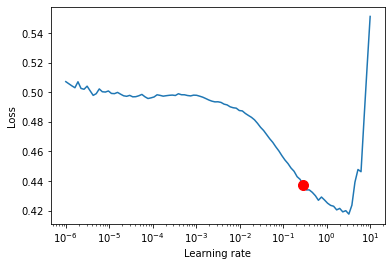

In [144]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# Треннировка модели

In [145]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    #output_size=7,  # 7 quantiles by default
    #loss=QuantileLoss(),
    output_size=1,
    loss=SMAPE(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Number of parameters in network: 24.9k


In [146]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | SMAPE                           | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 124   
3  | prescalers                         | ModuleDict                      | 192   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

# Настройка гиперпараметров

In [147]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=5,
    max_epochs=30,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=True,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)


------------------------


Finding best initial lr:  41%|████      | 41/100 [00:25<00:35,  1.66it/s]

Finding best initial lr:  42%|████▏     | 42/100 [00:25<00:34,  1.67it/s]

Finding best initial lr:  43%|████▎     | 43/100 [00:26<00:33,  1.69it/s]

Finding best initial lr:  44%|████▍     | 44/100 [00:26<00:32,  1.70it/s]

Finding best initial lr:  45%|████▌     | 45/100 [00:27<00:32,  1.70it/s]

Finding best initial lr:  46%|████▌     | 46/100 [00:27<00:31,  1.71it/s]

Finding best initial lr:  47%|████▋     | 47/100 [00:28<00:31,  1.68it/s]

Finding best initial lr:  48%|████▊     | 48/100 [00:29<00:30,  1.68it/s]

Finding best initial lr:  49%|████▉     | 49/100 [00:29<00:30,  1.69it/s]

Finding best initial lr:  50%|█████     | 50/100 [00:30<00:28,  1.77it/s]--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  51

In [148]:
# show best hyperparameters
print(study.best_trial.params)

{'gradient_clip_val': 0.3571367056117896, 'hidden_size': 71, 'dropout': 0.19548650102490592, 'hidden_continuous_size': 22, 'attention_head_size': 3, 'learning_rate': 0.0025118864315095803}


# Оценка

In [149]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [150]:
from sklearn import metrics
import numpy as np


# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
print('MAE: ', metrics.mean_absolute_error(actuals, predictions))
print('RMSE: ', metrics.mean_squared_error(actuals, predictions, squared=False))
print('R2: ', metrics.r2_score(actuals, predictions))

MAE:  669.36743
RMSE:  669.36743
R2:  nan


In [151]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

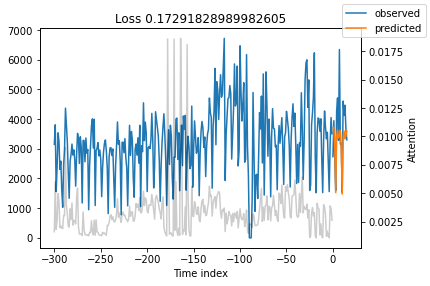

In [152]:
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

In [153]:
#raw_predictions

# Худшие

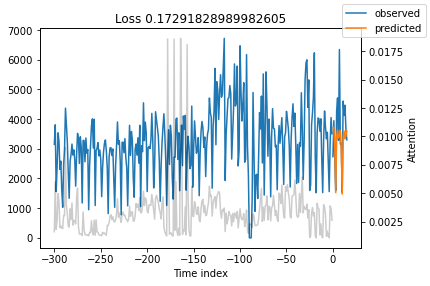

In [154]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    )

# Прогнозы и факты

Finding best initial lr: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


{'encoder_length': <Figure size 720x360 with 2 Axes>,
 'volume_center': <Figure size 720x360 with 2 Axes>,
 'volume_scale': <Figure size 720x360 with 2 Axes>,
 'time_idx': <Figure size 720x360 with 2 Axes>,
 'relative_time_idx': <Figure size 720x360 with 2 Axes>,
 'volume': <Figure size 720x360 with 2 Axes>,
 'log_volume': <Figure size 720x360 with 2 Axes>,
 'avg_volume_by_wh': <Figure size 720x360 with 2 Axes>,
 'avg_volume_by_weekday': <Figure size 720x360 with 2 Axes>,
 'avg_volume_by_mon': <Figure size 720x360 with 2 Axes>,
 'avg_volume_by_type': <Figure size 720x360 with 2 Axes>,
 'avg_volume_by_measure': <Figure size 720x360 with 2 Axes>,
 'warehouse_id': <Figure size 432x288 with 2 Axes>,
 'type_flow_id': <Figure size 432x288 with 2 Axes>,
 'measure_unit_id': <Figure size 432x288 with 2 Axes>,
 'special_days': <Figure size 432x288 with 2 Axes>,
 'year': <Figure size 432x288 with 2 Axes>,
 'month': <Figure size 720x360 with 2 Axes>,
 'weekday': <Figure size 432x288 with 2 Axes>}

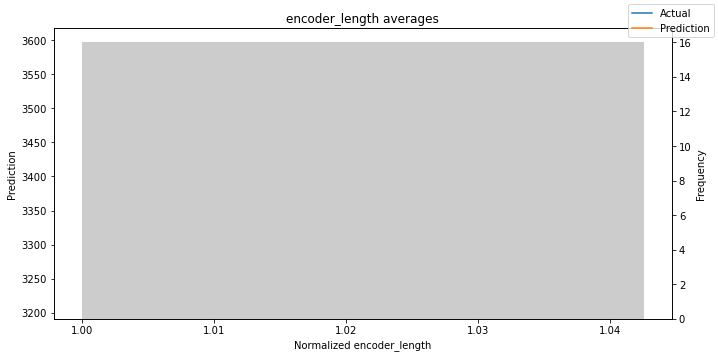

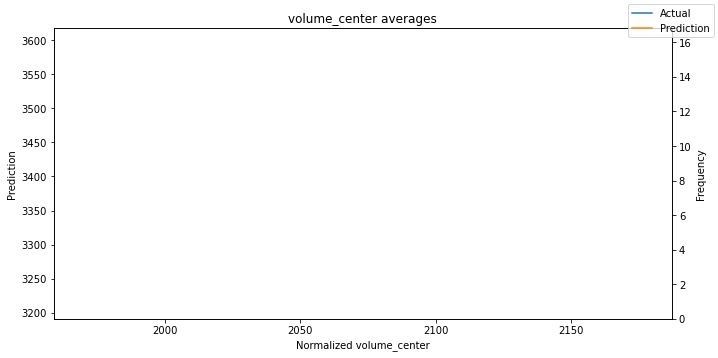

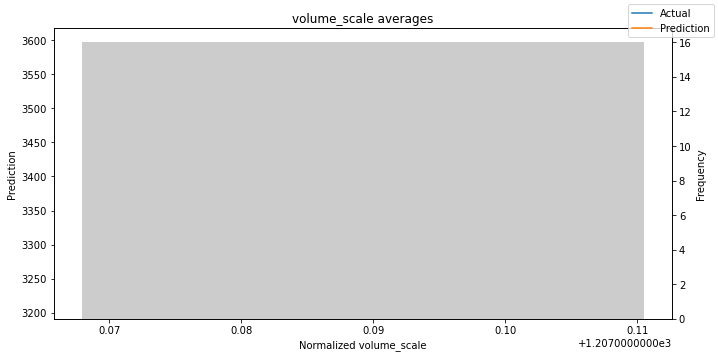

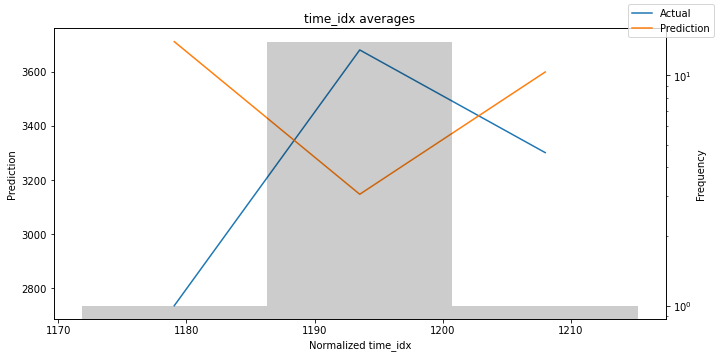

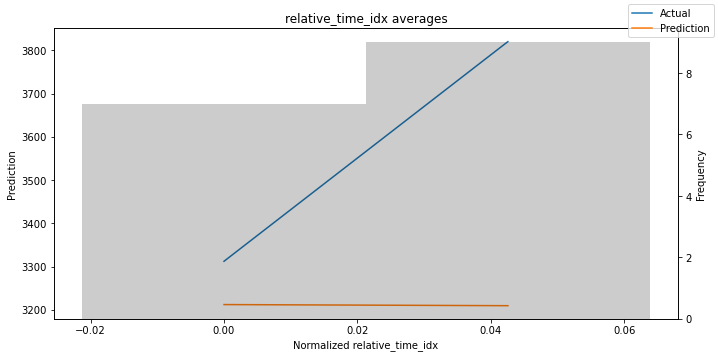

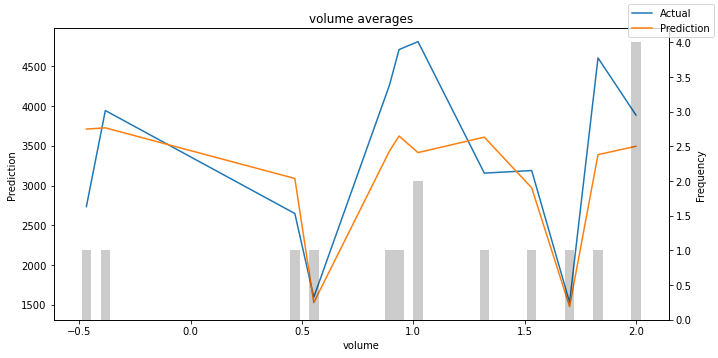

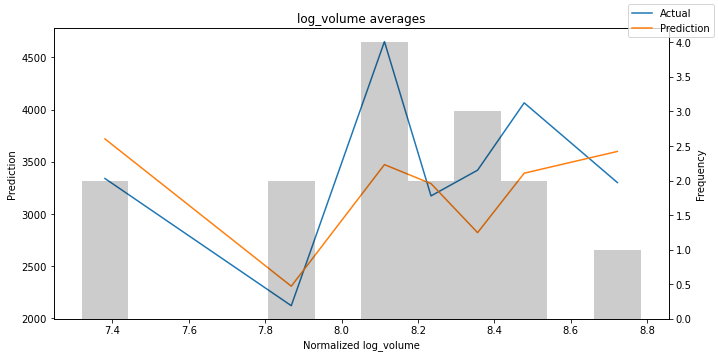

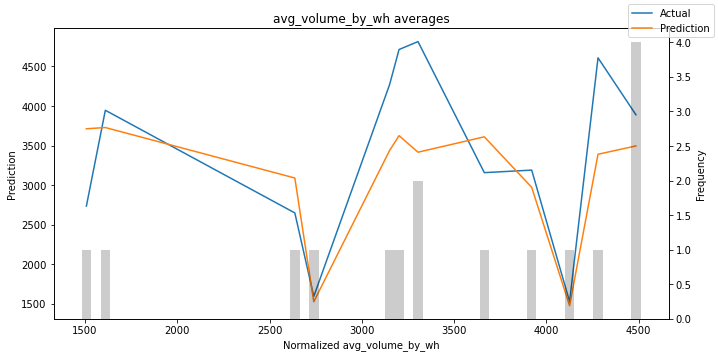

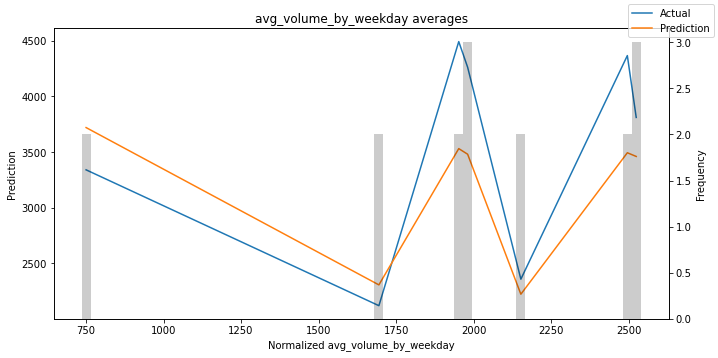

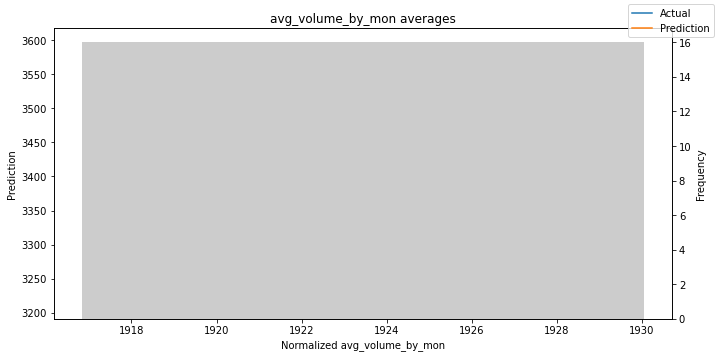

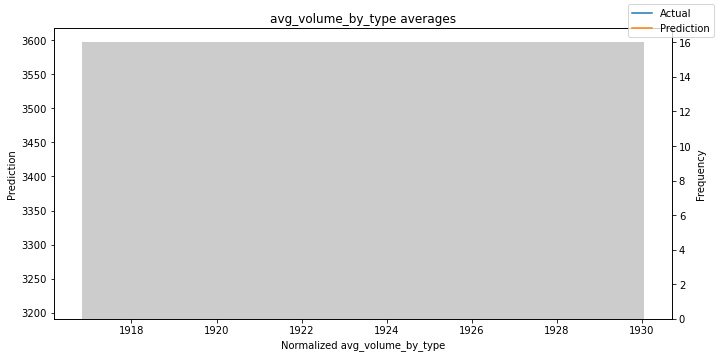

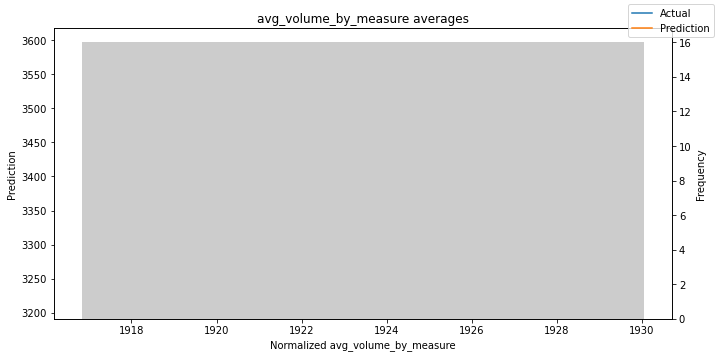

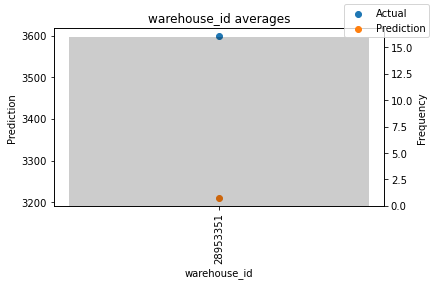

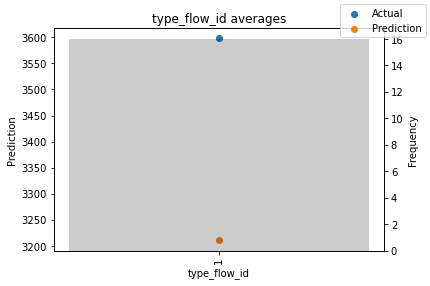

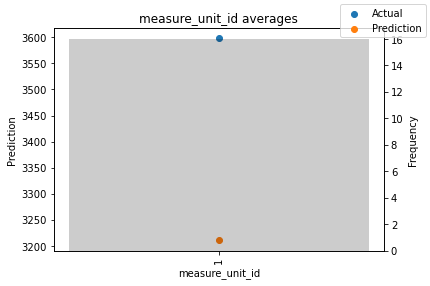

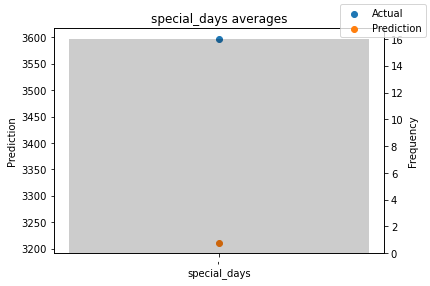

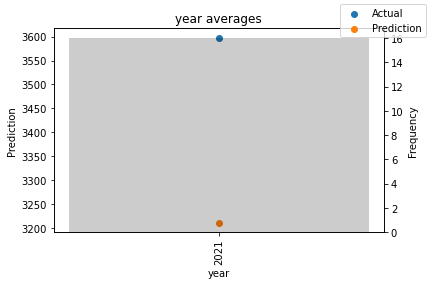

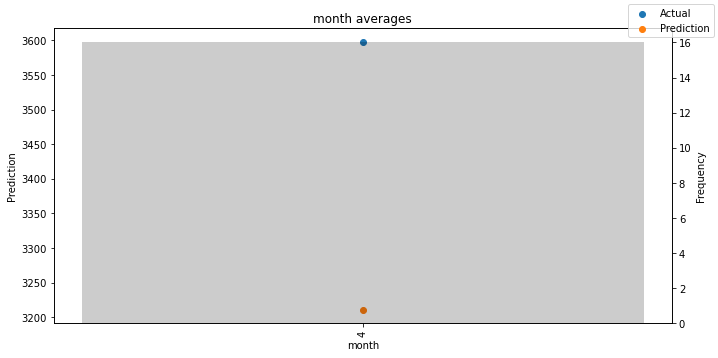

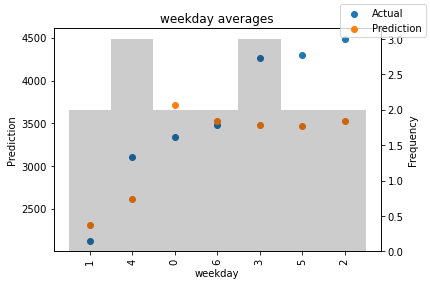

In [155]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [156]:
#predictions
#x
#predictions_vs_actuals
predictions = best_tft.predict(val_dataloader, return_x=False, return_index=True, mode='prediction')
predictions

[tensor([[3711.4888, 3727.1462, 3089.2446, 1525.1509, 3436.8022, 3624.0862,
          3369.9670, 3460.5620, 3609.8228, 2971.4915, 1475.6611, 3389.4321,
          3597.2803, 3336.9998, 3444.2075, 3599.1748]]),
    time_idx warehouse_id type_flow_id measure_unit_id
 0      1186     28953351            1               1]

In [157]:
prediction, prediction_index_df = best_tft.predict(val_dataloader, return_index=True, mode='prediction')
prediction_index_df["prediction"] = prediction[:, 0]  # pick first prediction after encoding

prediction_index_df
#prediction

,time_idx,warehouse_id,type_flow_id,measure_unit_id,prediction
0,1186,28953351,1,1,3711.48877


In [158]:
#data[['date', 'time_idx']].set_index('time_idx')


In [159]:
predictions = pd.DataFrame(columns=['time_idx', 'warehouse_id', 'type_flow_id', 'measure_unit_id', 'prediction'])
prediction, prediction_index_df = best_tft.predict(val_dataloader, return_index=True, mode='prediction')
start_index = prediction_index_df['time_idx'].values[0]

for i in range(max_prediction_length):    
    pred = prediction_index_df 
    pred['time_idx'] = start_index + i   
    pred['prediction'] = prediction[:, i]
    pred['prediction'] = round(pred['prediction'])
    predictions = pd.concat([predictions, pred])
  

new_df = pd.merge(data[['date', 'time_idx']].drop_duplicates(), predictions, on='time_idx')
#new_df
pred_df = pd.merge(new_df, data[['warehouse_id', 'time_idx', 'measure_unit_id', 'type_flow_id', 'volume']], on=['warehouse_id', 'time_idx', 'measure_unit_id', 'type_flow_id'])
pred_df.head(50)

,date,time_idx,warehouse_id,type_flow_id,measure_unit_id,prediction,volume
0,2021-04-01,1186,28953351,1,1,3711.0,2735
1,2021-04-02,1187,28953351,1,1,3727.0,3945
2,2021-04-03,1188,28953351,1,1,3089.0,2648
3,2021-04-04,1189,28953351,1,1,1525.0,1593
4,2021-04-05,1190,28953351,1,1,3437.0,4269
5,2021-04-06,1191,28953351,1,1,3624.0,4713
6,2021-04-07,1192,28953351,1,1,3370.0,3282
7,2021-04-08,1193,28953351,1,1,3461.0,6344
8,2021-04-09,1194,28953351,1,1,3610.0,3157
9,2021-04-10,1195,28953351,1,1,2971.0,3189


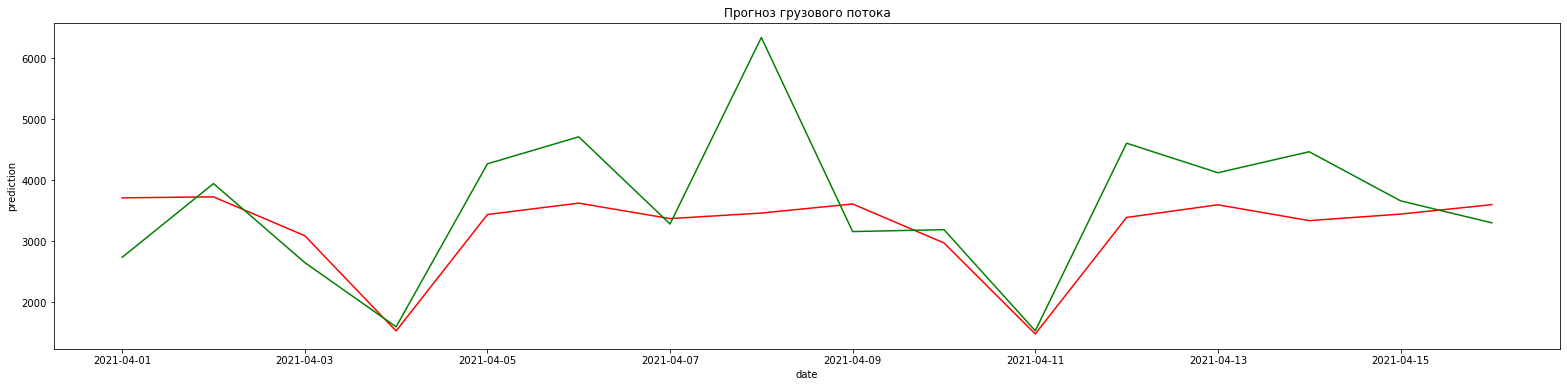

In [166]:
import seaborn as sns

plt.figure(figsize=(27, 6))
sns.lineplot(data=pred_df[(pred_df['measure_unit_id']=='1') & (pred_df['type_flow_id']=='1') & (pred_df['warehouse_id']=='28953351')], x="date", y="prediction", color='r')
sns.lineplot(data=pred_df[(pred_df['measure_unit_id']=='1') & (pred_df['type_flow_id']=='1') & (pred_df['warehouse_id']=='28953351')], x="date", y="volume", color='g')
plt.title('Прогноз грузового потока')
plt.show()

#[pred_df['measure_unit_id']=='2']

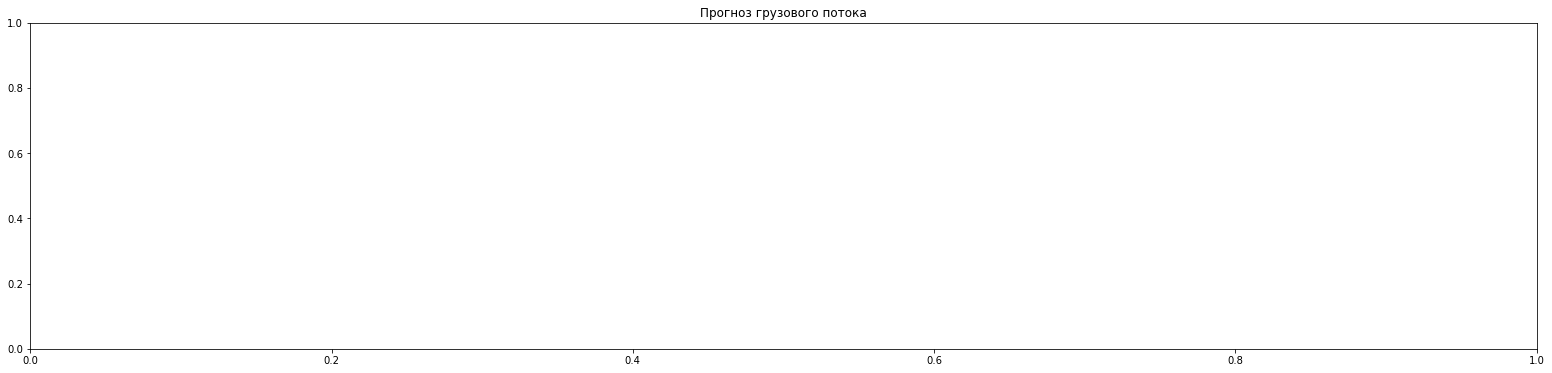

In [161]:
plt.figure(figsize=(27, 6))
sns.lineplot(data=pred_df[(pred_df['measure_unit_id']=='1') & (pred_df['type_flow_id']=='2') & (pred_df['warehouse_id']=='28953351')], x="date", y="prediction", color='r')
sns.lineplot(data=pred_df[(pred_df['measure_unit_id']=='1') & (pred_df['type_flow_id']=='2') & (pred_df['warehouse_id']=='28953351')], x="date", y="volume", color='g')
plt.title('Прогноз грузового потока')
plt.show()

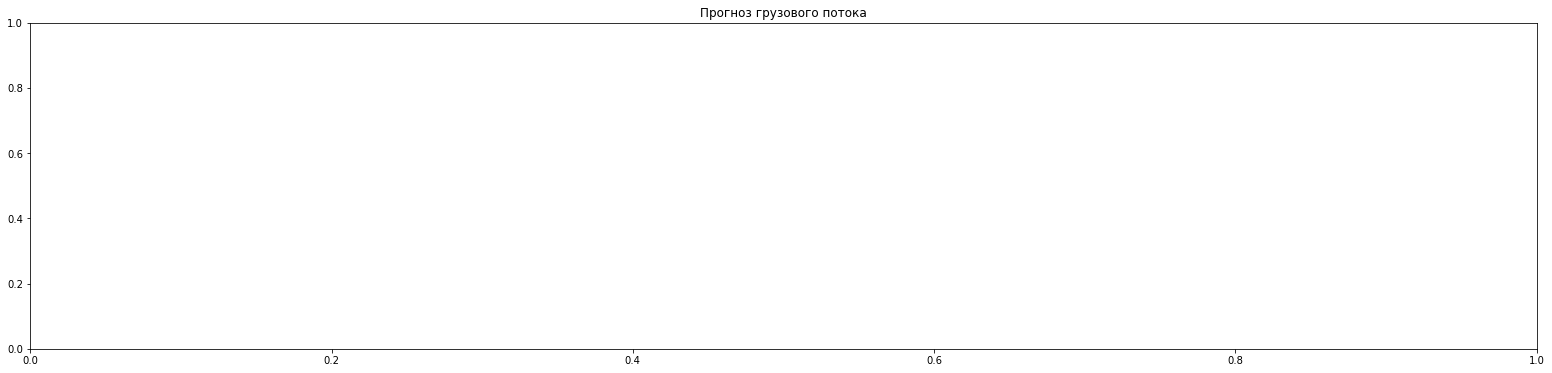

In [162]:
plt.figure(figsize=(27, 6))
sns.lineplot(data=pred_df[(pred_df['measure_unit_id']=='1') & (pred_df['type_flow_id']=='3') & (pred_df['warehouse_id']=='28953351')], x="date", y="prediction", color='r')
sns.lineplot(data=pred_df[(pred_df['measure_unit_id']=='1') & (pred_df['type_flow_id']=='3') & (pred_df['warehouse_id']=='28953351')], x="date", y="volume", color='g')
plt.title('Прогноз грузового потока')
plt.show()

In [163]:
#best_tft.transform_output(out = val_dataloader)
#best_tft.to_prediction(val_dataloader)

# Прогноз по выбранным данным

In [164]:
data.tail(16)

,date,warehouse_id,type_flow_id,measure_unit_id,new_year,time_idx,volume,year,month,weekday,log_volume,avg_volume_by_wh,avg_volume_by_weekday,avg_volume_by_mon,avg_volume_by_type,avg_volume_by_measure
1166,2021-04-01,28953351,1,1,-,1186,2735,2021,4,3,7.913887,2735.0,2531.875000,1921.980952,1921.980952,1921.980952
1167,2021-04-02,28953351,1,1,-,1187,3945,2021,4,4,8.280204,3945.0,1993.466667,1921.980952,1921.980952,1921.980952
1168,2021-04-03,28953351,1,1,-,1188,2648,2021,4,5,7.881560,2648.0,1697.785714,1921.980952,1921.980952,1921.980952
1169,2021-04-04,28953351,1,1,-,1189,1593,2021,4,6,7.373374,1593.0,477.357143,1921.980952,1921.980952,1921.980952
1170,2021-04-05,28953351,1,1,-,1190,4269,2021,4,0,8.359135,4269.0,1949.562500,1921.980952,1921.980952,1921.980952
1171,2021-04-06,28953351,1,1,-,1191,4713,2021,4,1,8.458080,4713.0,2494.733333,1921.980952,1921.980952,1921.980952
1172,2021-04-07,28953351,1,1,-,1192,3282,2021,4,2,8.096208,3282.0,2155.333333,1921.980952,1921.980952,1921.980952
1173,2021-04-08,28953351,1,1,-,1193,6344,2021,4,3,8.755265,6344.0,2531.875000,1921.980952,1921.980952,1921.980952
1174,2021-04-09,28953351,1,1,-,1194,3157,2021,4,4,8.057377,3157.0,1993.466667,1921.980952,1921.980952,1921.980952
1175,2021-04-10,28953351,1,1,-,1195,3189,2021,4,5,8.067463,3189.0,1697.785714,1921.980952,1921.980952,1921.980952


In [165]:
t = best_tft.predict(
    training.filter(lambda x: (x.warehouse_id == "28999900") & (x.type_flow_id == "1") & (x.measure_unit_id == "1") & (x.time_idx_first_prediction == 1160)),
    mode="prediction",
    #return_index=True,
)


ValueError: After applying filter no sub-sequences left in dataset

In [120]:
t

tensor([[26103.1719, 16353.9570, 19854.9043, 26862.1484, 25230.9727, 27887.0098,
         24600.6230, 24658.7148, 15024.9160, 18122.5156, 27555.3555, 24732.9824,
         30719.6777, 23190.2734, 22888.5684, 15666.8027]])

In [121]:
#from pytorch_forecasting import utils

pred_df = pd.DataFrame(t).astype("float")
pred_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,26103.171875,16353.957031,19854.904297,26862.148438,25230.972656,27887.009766,24600.623047,24658.714844,15024.916016,18122.515625,27555.355469,24732.982422,30719.677734,23190.273438,22888.568359,15666.802734


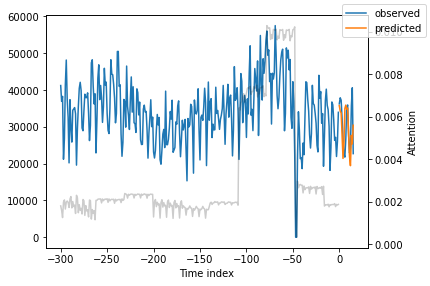

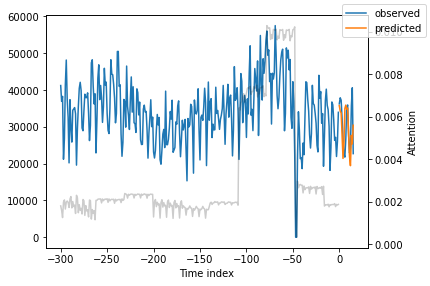

In [122]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.warehouse_id == "28999900") & (x.type_flow_id == "1") & (x.measure_unit_id == "1") & (x.time_idx_first_prediction == 1143)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0)

# Интерпретация

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x252 with 1 Axes>,
 'encoder_variables': <Figure size 504x378 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>}

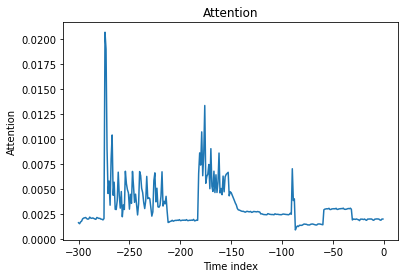

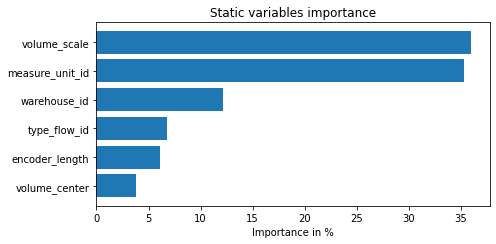

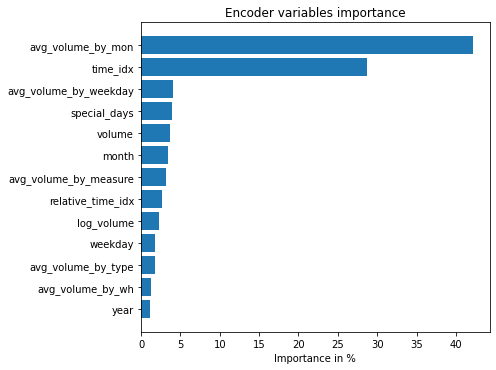

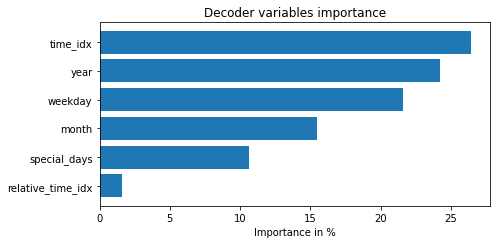

In [123]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [124]:
from torch.utils.tensorboard import SummaryWriter